In [565]:

import tensorflow.keras as tfk
import tensorflow as tf
import numpy as np
from PIL import Image
from numpy import expand_dims

In [566]:
def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [567]:
img=Image.open('/Users/ekansh/Downloads/000002.jpg')
print("image size:", img.size)
# img.show()


new_img = make_square(img)
new_img=new_img.resize((416,416))
# new_img.show()

arr = np.asarray(new_img)
# arr = np.asarray(img.resize((416,416)))
shape = arr.shape
print("image size as array:", shape)
# arr = arr.reshape(1, *shape)
arr = expand_dims(arr,0)
print("converted to 4d tensor:",arr.shape)
float_array = arr.astype(np.float)


float_array=float_array/255.0



image size: (335, 500)
image size as array: (416, 416, 3)
converted to 4d tensor: (1, 416, 416, 3)


In [568]:
import requests
import base64
import json

base_url='http://localhost:8501/v1/models/test'
resp=requests.get(base_url,verify=False)


data = json.dumps({"signature_def":"serving_default","instances":float_array.tolist()})
headers={"content-type":"application/json"}


rep=requests.post("http://localhost:8501/v1/models/test:predict",data=data,headers=headers)
# print(rep.text)

res=(json.loads(rep.text)['predictions'][0])
# print(len(res))
temp=np.asarray(res)
temp=expand_dims(temp,0)
print(temp.shape)

(1, 13, 13, 125)


In [569]:
# load sample data
# from Utilities.io import LoadPascal
# DATA_DIR = 'SampleData/Images'
# ANCHOR_PATH = 'SampleData/vocAnchors.txt'
# CLASSNAME_PATH = 'SampleData/vocClasses.txt'
# SHAPE = (416, 416, 3)
# loader = LoadPascal(imgDir=DATA_DIR, anchorPath=ANCHOR_PATH, classNamePath=CLASSNAME_PATH)
# data = loader.loadData(imgShape=SHAPE, batchSize=2, imgOnly=True, shuffle=True)

In [570]:
anchs=np.array([(1.3221, 1.73145),(3.19275, 4.00944),(5.05587, 8.09892),(9.47112, 4.84053),(11.2364, 10.0071)])
cl=np.array(["aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"
])


In [571]:
"""
extract bounding box coordinates from raw model outputs 
parameters:
    modelOuput: tensor, of shape (None, conv H, conv W, num anchors * (num class + 5))
    anchors: tensor, of shape (num anchors, 2)
    num class: int, number of classes 
returns:
    boxXY: tensor, of shape (None, conv H, conv W, num anchors, 2). The coordinates of box centers
    boxWH: tensor, of shape (None, conv H, conv W, num anchors, 2). The width and height of boxes
    objScore: tensor, of shae (None, conv H, conv W, num anchors, 1). The obj score of each anchor box 
    classProb: tensor, of shape (None, conv H, conv W, num anchors, num class). The class probabilities 
"""
def extractInfo(modelOutput, anchors, numClass):
    featureDim = modelOutput.shape
    numAnchor = anchors.shape[0]  # get the number of anchors, 5 for the Pascal dataset
    modelOutput = tf.reshape(modelOutput, shape=(-1, featureDim[1], featureDim[2], numAnchor, numClass + 5))
    """
    Now modelOutput has shape (-1, grid num W, grid num H, anchor num, 5+class num)
    For bounding box k in grid (i, j) in picture n, it is in stored in modelOutput[n, i, j, k, :]
    """
    imageShape = featureDim[1:3]  # get the width and height of output feature map

    """
    step 1: pass tx, ty through sigmoid and offset by grid coordinates so that we get bx, by
    Let's assume the raw boxXY = (0,0) and it's in grid (0,1)
    """
    boxXY = tf.nn.sigmoid(modelOutput[..., :2])  # boxXY now w.r.t top left corner of its grid(on grid scale)
    """
    now boxXY = (0.5, 0.5). It means it's 0.5 (grid weight) and 0.5(grid height) away from the top left corner of grid (0,1)
    the red dot in figure 3 shows its location
    """
    idx = getOffset(imageShape) # convert box center to grid scale
    idx = tf.cast(idx, modelOutput.dtype)
    anchors = tf.cast(tf.reshape(anchors, (1, 1, 1, numAnchor, 2)), idx.dtype)
    boxXY = (boxXY + idx)  
    """
    idx essentially converts the boxXY coordinates from w.r.t its own grid(0,1) to the black top left corner of gird (0,0)
    now boxXY = (0.5,0.5) + (0,1) = (0.5, 1.5), meaning it's 0.5 grid height and 1.5 grid width from tht black dot 
    for two boxes k1 and k2, their local overlapps iff boxXY 1 == boxXY 2 & they are in the same grid
    """
    
    """
    step 2: convert box width and hight 
    let's assume boxWH = (0.4, 0.4) and its anchor box has size (0.75, 0.5), which is shown as the blue box
    """
    boxWH = tf.math.exp(modelOutput[..., 2:4]) 
    """
    Now boxWH = (1.5, 1.5), meaning it's 1.5 times wider and taller than the anchor box
    """
    boxWH = boxWH * anchors
    """
    Now boxWH = (1.13, 0.75), meaning its width is 0.75 unit of grid width and height is 1.13 units of grid height, shown as
    the red box in figure 3. As you can see, for different anchors, boxWH = (1.13, 0.75) means different sizes
    """
    objScore = tf.nn.sigmoid(modelOutput[..., 4:5])  # objectiveness score; must be between 0 and 1
    classProb = tf.nn.softmax(modelOutput[..., 5:])  # probability of classes; pass through a softmax gate to obtain prob.
    
    return boxXY, boxWH, objScore, classProb

"""
generate grid offset for a given shape 
parameters:
    shape: tuple of length 2, [conv height, conv weidth]
returns:
    offset: tensor of shape [1. conv H, conv W, 1, 2]. 
"""


def getOffset(shape):
    hIndex = tf.reshape(tf.range(start=0, limit=shape[0]), (shape[0], 1))
    hIndex = tf.tile(hIndex, [1, shape[1]])  # expand in the height direction
    wIndex = tf.reshape(tf.range(start=0, limit=shape[1]), (1, shape[1]))
    wIndex = tf.tile(wIndex, [shape[0], 1])  # expand in the width direction
    idx = tf.stack([wIndex, hIndex], axis=-1)
    idx = tf.reshape(idx, shape=(1, *shape, 1, 2)) # reshape the offset so that it can add to boxXY directly
    return idx

In [572]:
"""
convert the box center and weight to top left and bottom right corners 
parameters: 
    boxXY: tensor, of shape (None, conv H, conv W, num anchors, 2). The coordinates of box centers w.r.t the top left grid center
    boxWH: tensor, of shape (None, conv H, conv W, num anchors, 2). The width and height of boxes on grid scale
returns:
    boxLoc: tensor, of shape (None, conv H, conv W, num anchors, 4). The top left and bottom right coordinates on grid scale
"""

def getBoxLoc(boxXY, boxWH):
    topLeft = boxXY - boxWH / 2  # top left
    
    bottomRight = boxXY + boxWH / 2  # bottom right
    # the last dimension is (x1, y1, x2, y2)
    # top left means it is closer to (0,0) in the image, which is the top-left corner
    # if displayed by matplotlib 
    return tf.concat([topLeft, bottomRight], axis=-1)

"""
scale the boxes to full image scale 
parameters: 
    boxLoc: tensor, of shape (None, conv H, conv W, num anchors, 4). The top left and bottom right coordinates 
    scale: tuple, value = (32, 32). This is because conv dim = img dim // 32 
returns:
    boxLoc: tensor, of shape (None, conv H, conv W, num anchors, 4). scaled version of boxLoc
"""

def scaleBox(boxLoc, scale=(32, 32)):
#     height, width = scale[0], scale[1]
    height, width = scale[0]*img.size[0]/416.0, scale[1]*img.size[1]/416.0
    shape = tf.stack([height, width, height, width])
    shape = tf.reshape(shape, [1, 4])
    shape = tf.cast(shape, boxLoc.dtype)
    return boxLoc * shape

In [573]:
"""
filter out boxes with low object score 
parameters:
    boxLoc: tensor, of shape (None, conv H, conv W, num anchors, 4). The top left and bottom right coordinates 
    objScore: tensor, of shae (None, conv H, conv W, num anchors, 1). The obj score of each anchor box 
    classProb: tensor, of shape (None, conv H, conv W, num anchors, num class). The class probabilities 
    scoreThresh: filter threshold
returns 
    boxes: list of boxes, [box1, box2, ...]
    objScore: list of scores, [score1, score2, ...]
    classProb: list of class probability, [prob1, prob2, ...]
"""


def filterBox(boxLoc, objScore, classProb, scoreThresh=0.5):
    boxScore = objScore * classProb  # (None, B1, B2, S, NCLASS)
    boxClass = tf.argmax(boxScore, axis=-1)  # shape = (None, S, S, B)
    boxScore = tf.math.reduce_max(boxScore, axis=-1)  # shape = (None, S, S, B)
    mask = boxScore >= scoreThresh
    # filter out low-confidence boxes
    boxes = tf.boolean_mask(boxLoc, mask)
    scores = tf.boolean_mask(boxScore, mask)
    classes = tf.boolean_mask(boxClass, mask)
    """
    please note that tf.boolean_maks returns a list rather than maintaining the original shapes. In
    other words, boxes is a list of boxes with no specific ordering. box[0] could be the coordinates of a box in grid 1,1 or 0,0
    """
    return boxes, scores, classes


"""
filter out boxes that are significantly overlapped. Only preserve the box with the highest score.
This function should be called after filterBox to reduce workload
parameters:
    boxLoc: list of tensor, [box1, box2, ...]
    objScore: lit of tensor, [score1, score 2]
    iouThresh: float, filter threshold 
returns:
    boxLoc: list of tensor, [box1, box2, ...] boxes left 
    objScore: lit of tensor, [score1, score 2] their scores 
"""


def nonMaxSuppress(boxLoc, score, classPredict, maxBox=20, iouThresh=0.5):
    boxLoc=np.float32(boxLoc)
    score=np.float32(score)
    idx = tf.image.non_max_suppression(boxLoc, score, maxBox, iou_threshold=iouThresh)
    boxLoc = tf.gather(boxLoc, idx)
    score = tf.gather(score, idx)
    classPredict = tf.gather(classPredict, idx)
    return boxLoc, score, classPredict

In [574]:
"""
convert raw yolo output to a list of boxes
parameters:
    featureMap: tensor, (None, conv H, conv W, num anchors * (num class + 5))
    anchors:  tensor, (num anchors, 2) [[w, h],[w, h],...]
    numClass: int, the number of classes 
    maxBox: int, the maximum number of boxes returned 
    scoreThresh: float, used to filter out low confidence boxes 
    iouThresh: float, used to filter out boxes that are significantly overlapped 
returns:
    generator of values: 
        boxes: list of boxes for one image [[left top right bottom], [], []]
        scores: list of scores for those boxes [score1, score2, ...]
        classes: class prediction [pred1, pred2, ...]
    
"""

def raw2Box(featureMap, anchors, numClass, maxBox=20, scoreThresh=0.5, iouThresh=0.6):
    # convert coordinates 
    print('YOLO output shape: ', featureMap.shape)
    batchXY, batchWH, batchScore, batchProb = extractInfo(featureMap, anchors, numClass)
    # convert boxXY,boxWH to corner coordinates 
    batchLoc = getBoxLoc(batchXY, batchWH)
    # scale the coordinates from grid scale to image scale 
    batchLoc = scaleBox(batchLoc)
    print('Processed box coordinate shape: ', batchLoc.shape)
    # a for loop is needed because different images have various number of boxes
    # for each image, let's do:
    for boxLoc, objScore, classProb in zip(batchLoc, batchScore, batchProb):
        # filter out low confidence boxes
        boxes, scores, classes = filterBox(boxLoc, objScore, classProb, scoreThresh)
        # filter out overlapped boxes
        boxes, scores, classes = nonMaxSuppress(boxes, scores, classes, maxBox, iouThresh)
        # return a list of boxes for that image 
        print('box count: ', len(boxes))
        return boxes, scores, classes

In [575]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
class Visualizer:
    def __init__(self, classNames=[]):
        if len(classNames) == 0:
            self.colorMap = None
            self.classNames = []
        else:
            # assign random color to each class
            self.colorMap = colorMap = [(1, np.random.rand(), np.random.rand()) for i in range(len(classNames))]
            self.classNames = classNames

    def drawBox(self, image, boxes, scores=[], classes=[]):
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10,10)
        ax.set_axis_off()
        # sanity check
        if len(classes) > 0 and np.max(classes) > len(self.colorMap) - 1:
            print('make sure the class name list provided at initialization matches the class predictions')
            return None
        ax.imshow(image, aspect='auto')
        for i, box in enumerate(boxes):
            coor = [box[0], box[1]]
            #coor[0] = np.clip(coor[0], a_min=0, a_max=image.shape[1])
            #coor[1] = np.clip(coor[1], a_min=0, a_max=image.shape[0])
            
            w, h = box[2] - box[0], box[3] - box[1]
#             nx=img.size[0]/416.0
#             ny=img.size[1]/416.0
#             w, h = (box[2] - box[0])*nx, (box[3] - box[1])*ny       

            #w = np.clip(w, a_min=0, a_max=image.shape[1])
            #h = np.clip(h, a_min=0, a_max=image.shape[0])
            if self.colorMap and len(classes) > 0:
                rec = patches.Rectangle(coor, w, h, fill=False, color=self.colorMap[classes[i]])
            else:
                rec = patches.Rectangle(coor, w, h, fill=False)
            ax.add_patch(rec)
            info = ''
            if len(classes) > 0 or self.classNames:
                info += self.classNames[classes[i]]
            if len(scores) > 0 != None:
                info += '{0:.2f}'.format(scores[i])
            if info == '':  # do not create text boxes
                continue
            if self.colorMap is None or len(classes) == 0:
                fill = dict(boxstyle='square,pad=0.2')
            else:
                fill = dict(boxstyle='square,pad=0.2', facecolor=self.colorMap[classes[i]])
            ax.text(*coor, s=info, bbox=fill)
            
        return fig

In [576]:
boxes, scores, classes=raw2Box(temp, anchors=anchs, numClass=len(cl),scoreThresh=0.5, iouThresh=0.6)

YOLO output shape:  (1, 13, 13, 125)
Processed box coordinate shape:  (1, 13, 13, 5, 4)
box count:  1


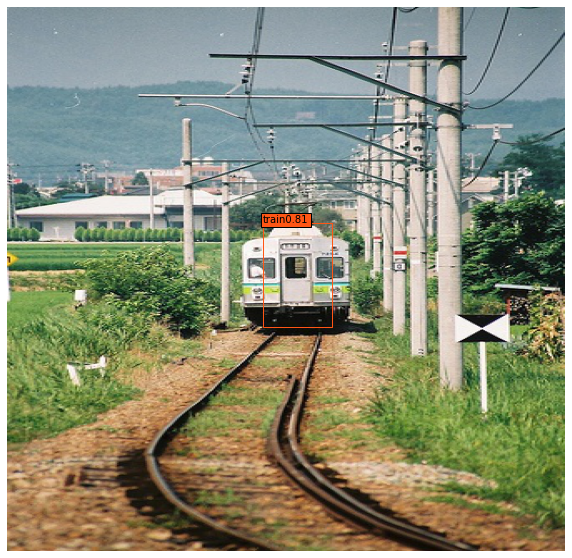

In [577]:
painter = Visualizer(cl)

fig = painter.drawBox(img, boxes.numpy(), scores.numpy(), classes.numpy())


In [578]:
# # from Utilities.painter import Visualizer
# painter = Visualizer(loader.classList)

# for imgs, names in data.take(2):
#     output = model.predict(imgs)
    
#     # scoreThresh is used to filter out boxes that have low object confidence 
#     # iouThresh is used to filter out boxes that overlap too much
#     results = raw2Box(output, anchors=loader.anchors, numClass=len(loader.classList),
#                      scoreThresh=0.2, iouThresh=0.3)
#     # iterate through the batch as the painter can only handle one image at a time
#     for image, (boxes, scores, classes) in zip(imgs, results):
#         fig = painter.drawBox(image, boxes.numpy(), scores.numpy(), classes.numpy())

In [579]:
# from matplotlib import pyplot
# from matplotlib.patches import Rectangle
# def draw_boxes(filename, v_boxes, v_labels, v_scores):
# 	# load the image
# 	data = img
    
# 	# plot the image
# 	pyplot.imshow(data)
# 	# get the context for drawing boxes
# 	ax = pyplot.gca()
# 	# plot each box
# 	for i in range(len(v_boxes)):
# 		box = v_boxes[i]
# 		# get coordinates
# 		y1, x1, y2, x2 = box[1], box[0], box[3], box[2]
# 		# calculate width and height of the box
# 		width, height = x2 - x1, y2 - y1
# 		# create the shape
# 		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
# 		# draw the box
# 		ax.add_patch(rect)
# 		# draw text and score in top left corner
# 		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
# 		pyplot.text(x1, y1, label, color='white')
# 	# show the plot
# 	pyplot.show()
    
# draw_boxes('image.jpg',boxes, scores, classes) 